In [11]:
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os
import tensorflow
from tensorflow.python.client import device_lib
import time
#print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tensorflow.test.is_gpu_available()


True

## Load from keras.datasets.cifar10

In [12]:
train, test = keras.datasets.cifar10.load_data()
x_train, y_train = train[0], train[1]
x_test, y_test = test[0], test[1]

## Preprocessing

In [13]:
def preprocessing(x):
    x = x / 255.
    return x.reshape(x.shape[0], -1)

def label_OHE(y):
    return keras.utils.to_categorical(y)

x_train = preprocessing(x_train)
x_test = preprocessing(x_test)
y_train = label_OHE(y_train)
y_test = label_OHE(y_test)
print('train:', x_train.shape, y_train.shape)
print('test:', x_test.shape, y_test.shape)

train: (50000, 3072) (50000, 10)
test: (10000, 3072) (10000, 10)


## Create Model(MLP)
- Add Batch Nomalization Layer befor each DenseLayer

In [14]:
h_list = [512, 256, 128]
drop_list = [0.25, 0.25, 0.25]
def build_mlp(input_shape=x_train.shape[-1:], output_shape=y_train.shape[-1],
              hidden=h_list, reg={'L2':1e-5}, drop = drop_list):
    keras.backend.clear_session()
    
    if list(reg.keys())[0] == 'L2':
        r = keras.regularizers.l2(reg['L2'])
    elif list(reg.keys())[0] == 'L1':
        r = keras.regularizers.l1(reg['L1'])
    else:
        r = keras.regularizers.l1_l2(reg['L1_L2'])
        
    input_layer = keras.layers.Input(input_shape)
    for idx, h in enumerate(hidden):
        if idx == 0:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(input_layer)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        else:
            x = keras.layers.Dense(units=h, activation='relu', kernel_regularizer=r)(x)
            x = keras.layers.BatchNormalization(axis=-1)(x)
            x = keras.layers.Dropout(drop[idx])(x)
        output_layer = keras.layers.Dense(units=output_shape, activation='softmax')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

model = build_mlp()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

## HyperParameters

In [15]:
EPOCHS = 100
BATCH_SIZE_LIST = [50]
LEARNING_RATE = 1e-3
MOMENTUM = 0.95
#set optimizer
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)#, momentum=MOMENTUM)

## Training (Add Callback)

In [16]:
callback=1
def model_train(model=model, optimizer=optimizer, 
                train = (x_train, y_train), valid = (x_test, y_test),
                e=EPOCHS, bs = BATCH_SIZE_LIST[-1], CALLBACKS= callback):
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train[0], train[1], validation_data=valid, 
              epochs=e, batch_size=bs, shuffle=True, callbacks=CALLBACKS) #add callback "early stop"
    train_loss = model.history.history['loss']
    valid_loss = model.history.history['val_loss']
    train_acc = model.history.history['acc']
    valid_acc = model.history.history['val_acc']
    record = {'train_loss':train_loss,
              'valid_loss':valid_loss,
              'train_acc': train_acc,
              'valid_acc': valid_acc}
    return model, record

## ReduceLROnPlateau

In [17]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',verbose=1,
                                             save_best_only=True)
CALLBACKS = [early_stop, checkpoint, lr_reducer]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 167us/step - loss: 1.9886 - acc: 0.3119 - val_loss: 1.6687 - val_acc: 0.4076

Epoch 00001: val_loss improved from inf to 1.66874, saving model to cifar10_dnn.h5
Epoch 2/100
50000/50000 [==============================] - 8s 158us/step - loss: 1.7323 - acc: 0.3872 - val_loss: 1.6009 - val_acc: 0.4292

Epoch 00002: val_loss improved from 1.66874 to 1.60087, saving model to cifar10_dnn.h5
Epoch 3/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.6683 - acc: 0.4099 - val_loss: 1.5565 - val_acc: 0.4448

Epoch 00003: val_loss improved from 1.60087 to 1.55651, saving model to cifar10_dnn.h5
Epoch 4/100
50000/50000 [==============================] - 7s 146us/step - loss: 1.6279 - acc: 0.4279 - val_loss: 1.5134 - val_acc: 0.4650

Epoch 00004: val_loss improved from 1.55651 to 1.51341, saving model to cifar10_dnn.h5
Epoch 5/100
50000/50000 [=====================

50000/50000 [==============================] - 7s 145us/step - loss: 1.3754 - acc: 0.5143 - val_loss: 1.3351 - val_acc: 0.5252

Epoch 00040: val_loss did not improve from 1.31529
Epoch 41/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.3717 - acc: 0.5155 - val_loss: 1.3303 - val_acc: 0.5326

Epoch 00041: val_loss did not improve from 1.31529
Epoch 42/100
50000/50000 [==============================] - 7s 144us/step - loss: 1.3748 - acc: 0.5176 - val_loss: 1.3176 - val_acc: 0.5354

Epoch 00042: val_loss did not improve from 1.31529
Epoch 43/100
50000/50000 [==============================] - 7s 143us/step - loss: 1.3687 - acc: 0.5177 - val_loss: 1.3197 - val_acc: 0.5326

Epoch 00043: val_loss did not improve from 1.31529

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 44/100
50000/50000 [==============================] - 8s 157us/step - loss: 1.3578 - acc: 0.5238 - val_loss: 1.3164 - val_acc: 0.5364

Epoch 00044: val_loss d

## Load Back

In [20]:
model = build_mlp()
model = keras.models.load_model('cifar10_dnn.h5')
loss_loadback, acc_loadbcak = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 80us/step


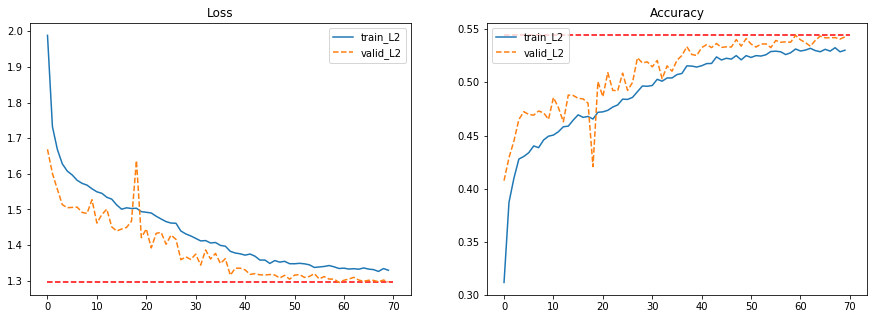

In [21]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
            
plot_result(record, 'L2', ax1, ax2)
ax1.hlines(y=loss_loadback, xmin=0, xmax=len(record['train_loss']), linestyle='--', color='r')
ax2.hlines(y=acc_loadbcak, xmin=0, xmax=len(record['train_acc']), linestyle='--', color='r')
plt.show()

## Other reduce leanrning condition (factor & patient)

In [22]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.1)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',verbose=1,
                                             save_best_only=True)
CALLBACKS = [early_stop, checkpoint, lr_reducer]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 8s 168us/step - loss: 1.9954 - acc: 0.3138 - val_loss: 1.6710 - val_acc: 0.4116

Epoch 00001: val_loss improved from inf to 1.67103, saving model to cifar10_dnn.h5
Epoch 2/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.7388 - acc: 0.3821 - val_loss: 1.6119 - val_acc: 0.4309

Epoch 00002: val_loss improved from 1.67103 to 1.61187, saving model to cifar10_dnn.h5
Epoch 3/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.6816 - acc: 0.4054 - val_loss: 1.5872 - val_acc: 0.4410

Epoch 00003: val_loss improved from 1.61187 to 1.58720, saving model to cifar10_dnn.h5
Epoch 4/100
50000/50000 [==============================] - 7s 145us/step - loss: 1.6437 - acc: 0.4188 - val_loss: 1.5426 - val_acc: 0.4426

Epoch 00004: val_loss improved from 1.58720 to 1.54258, saving model to cifar10_dnn.h5
Epoch 5/100
50000/50000 [=====================

In [23]:
print(os.listdir(os.getcwd()))

['cifar10_dnn.h5', '__notebook_source__.ipynb', '.ipynb_checkpoints']


In [27]:
model = build_mlp()
model = keras.models.load_model('cifar10_dnn.h5')
loss_loadback, acc_loadbcak = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 83us/step


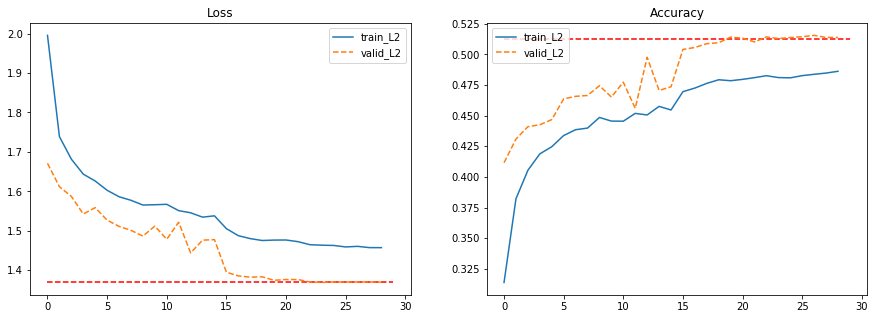

In [28]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
            
plot_result(record, 'L2', ax1, ax2)
ax1.hlines(y=loss_loadback, xmin=0, xmax=len(record['train_loss']), linestyle='--', color='r')
ax2.hlines(y=acc_loadbcak, xmin=0, xmax=len(record['train_acc']), linestyle='--', color='r')
plt.show()

## Try Adam optimizer

In [29]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',verbose=1,
                                             save_best_only=True)
CALLBACKS = [early_stop, checkpoint, lr_reducer]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 10s 201us/step - loss: 1.9511 - acc: 0.3201 - val_loss: 1.9886 - val_acc: 0.3245

Epoch 00001: val_loss improved from inf to 1.98855, saving model to cifar10_dnn.h5
Epoch 2/100
50000/50000 [==============================] - 9s 174us/step - loss: 1.7320 - acc: 0.3872 - val_loss: 2.2627 - val_acc: 0.2401

Epoch 00002: val_loss did not improve from 1.98855
Epoch 3/100
50000/50000 [==============================] - 9s 174us/step - loss: 1.6882 - acc: 0.4023 - val_loss: 1.8732 - val_acc: 0.3423

Epoch 00003: val_loss improved from 1.98855 to 1.87317, saving model to cifar10_dnn.h5
Epoch 4/100
50000/50000 [==============================] - 9s 173us/step - loss: 1.6652 - acc: 0.4104 - val_loss: 1.6292 - val_acc: 0.4282

Epoch 00004: val_loss improved from 1.87317 to 1.62924, saving model to cifar10_dnn.h5
Epoch 5/100
50000/50000 [==============================] - 9s 173us/step - loss: 

50000/50000 [==============================] - 9s 171us/step - loss: 1.3409 - acc: 0.5311 - val_loss: 1.3447 - val_acc: 0.5274

Epoch 00039: val_loss did not improve from 1.31296
Epoch 40/100
50000/50000 [==============================] - 9s 173us/step - loss: 1.3380 - acc: 0.5306 - val_loss: 1.3407 - val_acc: 0.5293

Epoch 00040: val_loss did not improve from 1.31296
Epoch 41/100
50000/50000 [==============================] - 9s 173us/step - loss: 1.3248 - acc: 0.5359 - val_loss: 1.3053 - val_acc: 0.5404

Epoch 00041: val_loss improved from 1.31296 to 1.30532, saving model to cifar10_dnn.h5
Epoch 42/100
50000/50000 [==============================] - 9s 173us/step - loss: 1.3291 - acc: 0.5336 - val_loss: 1.3307 - val_acc: 0.5319

Epoch 00042: val_loss did not improve from 1.30532
Epoch 43/100
50000/50000 [==============================] - 9s 171us/step - loss: 1.3278 - acc: 0.5357 - val_loss: 1.3290 - val_acc: 0.5322

Epoch 00043: val_loss did not improve from 1.30532
Epoch 44/100
5000

50000/50000 [==============================] - 9s 171us/step - loss: 1.2377 - acc: 0.5652 - val_loss: 1.2567 - val_acc: 0.5592

Epoch 00078: val_loss did not improve from 1.25668
Epoch 79/100
50000/50000 [==============================] - 8s 169us/step - loss: 1.2336 - acc: 0.5678 - val_loss: 1.2573 - val_acc: 0.5586

Epoch 00079: val_loss did not improve from 1.25668
Epoch 80/100
50000/50000 [==============================] - 8s 170us/step - loss: 1.2313 - acc: 0.5677 - val_loss: 1.2597 - val_acc: 0.5584

Epoch 00080: val_loss did not improve from 1.25668
Epoch 81/100
50000/50000 [==============================] - 8s 169us/step - loss: 1.2283 - acc: 0.5721 - val_loss: 1.2586 - val_acc: 0.5571

Epoch 00081: val_loss did not improve from 1.25668

Epoch 00081: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 82/100
50000/50000 [==============================] - 8s 170us/step - loss: 1.2271 - acc: 0.5713 - val_loss: 1.2563 - val_acc: 0.5585

Epoch 00082: val_loss i

In [33]:
model = build_mlp()
model.load_weights('cifar10_dnn.h5')
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
loss_loadback, acc_loadbcak = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 79us/step


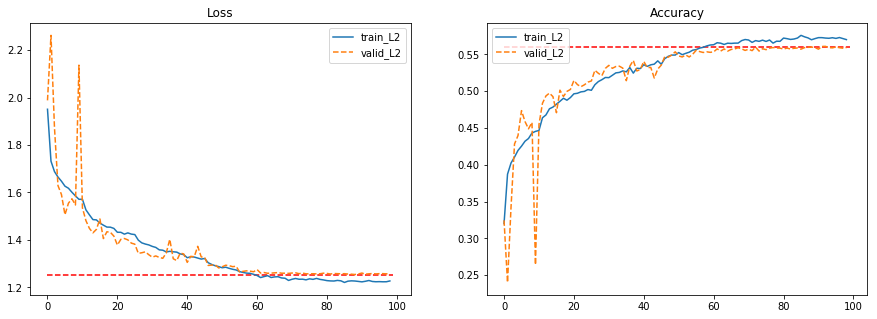

In [34]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
            
plot_result(record, 'L2', ax1, ax2)
ax1.hlines(y=loss_loadback, xmin=0, xmax=len(record['train_loss']), linestyle='--', color='r')
ax2.hlines(y=acc_loadbcak, xmin=0, xmax=len(record['train_acc']), linestyle='--', color='r')
plt.show()

## Try RMSProp optimizer

In [35]:
start = time.time()
model = build_mlp()
optimizer = keras.optimizers.RMSprop(lr=LEARNING_RATE)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
lr_reducer = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1, factor=0.5)
checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
                                             filepath='cifar10_dnn.h5',verbose=1,
                                             save_best_only=True)
CALLBACKS = [early_stop, checkpoint, lr_reducer]
model , record = model_train(model, optimizer, CALLBACKS=CALLBACKS)
duration = time.time() - start
print('{:.0f} mins {:.0f} secs'.format(duration//60, duration%60))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 186us/step - loss: 1.9496 - acc: 0.3222 - val_loss: 2.1609 - val_acc: 0.3163

Epoch 00001: val_loss improved from inf to 2.16090, saving model to cifar10_dnn.h5
Epoch 2/100
50000/50000 [==============================] - 8s 160us/step - loss: 1.7101 - acc: 0.3949 - val_loss: 1.9136 - val_acc: 0.3309

Epoch 00002: val_loss improved from 2.16090 to 1.91361, saving model to cifar10_dnn.h5
Epoch 3/100
50000/50000 [==============================] - 8s 160us/step - loss: 1.6518 - acc: 0.4128 - val_loss: 1.9219 - val_acc: 0.3353

Epoch 00003: val_loss did not improve from 1.91361
Epoch 4/100
50000/50000 [==============================] - 8s 158us/step - loss: 1.6277 - acc: 0.4213 - val_loss: 1.7418 - val_acc: 0.3886

Epoch 00004: val_loss improved from 1.91361 to 1.74177, saving model to cifar10_dnn.h5
Epoch 5/100
50000/50000 [==============================] - 8s 157us/step - loss: 1

50000/50000 [==============================] - 8s 160us/step - loss: 1.3010 - acc: 0.5454 - val_loss: 1.2985 - val_acc: 0.5454

Epoch 00040: val_loss improved from 1.31419 to 1.29849, saving model to cifar10_dnn.h5
Epoch 41/100
50000/50000 [==============================] - 8s 159us/step - loss: 1.2927 - acc: 0.5482 - val_loss: 1.3003 - val_acc: 0.5484

Epoch 00041: val_loss did not improve from 1.29849
Epoch 42/100
50000/50000 [==============================] - 8s 157us/step - loss: 1.2950 - acc: 0.5484 - val_loss: 1.3092 - val_acc: 0.5417

Epoch 00042: val_loss did not improve from 1.29849
Epoch 43/100
50000/50000 [==============================] - 8s 157us/step - loss: 1.2978 - acc: 0.5480 - val_loss: 1.3153 - val_acc: 0.5435

Epoch 00043: val_loss did not improve from 1.29849
Epoch 44/100
50000/50000 [==============================] - 8s 157us/step - loss: 1.2926 - acc: 0.5502 - val_loss: 1.3015 - val_acc: 0.5411

Epoch 00044: val_loss did not improve from 1.29849
Epoch 45/100
5000

50000/50000 [==============================] - 8s 157us/step - loss: 1.2221 - acc: 0.5741 - val_loss: 1.2645 - val_acc: 0.5569

Epoch 00079: val_loss did not improve from 1.26417
Epoch 80/100
50000/50000 [==============================] - 8s 156us/step - loss: 1.2233 - acc: 0.5720 - val_loss: 1.2636 - val_acc: 0.5572

Epoch 00080: val_loss improved from 1.26417 to 1.26359, saving model to cifar10_dnn.h5
Epoch 81/100
50000/50000 [==============================] - 8s 155us/step - loss: 1.2232 - acc: 0.5764 - val_loss: 1.2651 - val_acc: 0.5566

Epoch 00081: val_loss did not improve from 1.26359
Epoch 82/100
50000/50000 [==============================] - 8s 154us/step - loss: 1.2225 - acc: 0.5751 - val_loss: 1.2639 - val_acc: 0.5585

Epoch 00082: val_loss did not improve from 1.26359
Epoch 83/100
50000/50000 [==============================] - 8s 155us/step - loss: 1.2242 - acc: 0.5721 - val_loss: 1.2641 - val_acc: 0.5579

Epoch 00083: val_loss did not improve from 1.26359
Epoch 84/100
5000

In [36]:
model = build_mlp()
model.load_weights('cifar10_dnn.h5')
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
loss_loadback, acc_loadbcak = model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 75us/step


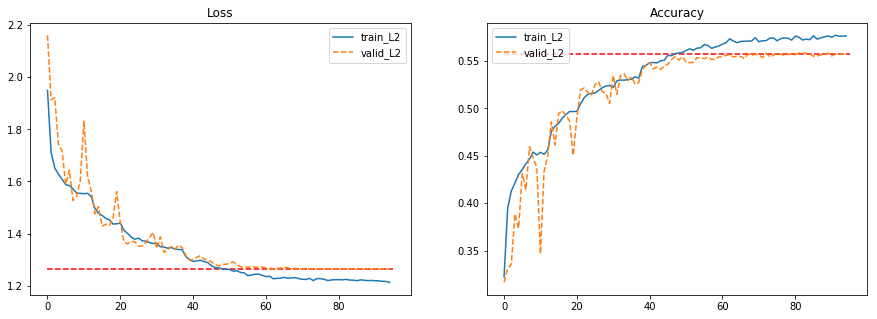

In [37]:
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
def plot_result(result_, title_, ax1, ax2):
    
    for idx, k in enumerate((result_.keys())):
        if k[-4:] == 'loss':
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'

            ax1.plot(range(len(result_[k])), result_[k], line, label = l)
            ax1.set_title('Loss')
            ax1.legend()
        else:
            if k[0] == 't':
                l, line = 'train_'+ title_, '-'
            else:
                l, line = 'valid_'+ title_, '--'
            ax2.plot(range(len(result_[k])), result_[k], line, label= l)
            ax2.set_title('Accuracy')
            ax2.legend()
        
            
plot_result(record, 'L2', ax1, ax2)
ax1.hlines(y=loss_loadback, xmin=0, xmax=len(record['train_loss']), linestyle='--', color='r')
ax2.hlines(y=acc_loadbcak, xmin=0, xmax=len(record['train_acc']), linestyle='--', color='r')
plt.show()